In [1]:
import numpy as np
np.random.seed(1001)

import os
import shutil
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import h5py
from utils.preprocessing import normalize_mel_histogram, convert2mel, normalize_amplitude, windowing


%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
train = pd.read_csv('../../real_data/FSDnoisy18k.meta/train_set.csv')
train.shape#test = pd.read_csv("../../real_data/sample_submission.csv")


(17310, 6)

In [4]:
train.shape

(17310, 6)

In [5]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

Using TensorFlow backend.


In [8]:
class Config(object):
    def __init__(self,
                 sampling_rate=44100, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [9]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  30
Maximum samples per category =  72


In [10]:
pwd

'/home/fabian/Dropbox/FabianCloud/MscAI/SecondSemester/MLP Second Semester/PersonalRepo/MLPProjectAudio'

In [20]:
# JUST RUN ONCE!!
#import wave
#path = '../../data/audio_train'

#maximum_audio_frame = 1323000  # THIS WAS OBTAINED IN A FORMER RUN.

#for audio in train['fname']:
#    wav = wave.open(path + "/" + audio)
#    if wav.getnframes() > maximum_audio_frame:
#        maximum_audio_frame = wav.getnframes()
#print(maximum_audio_frame)

1323000


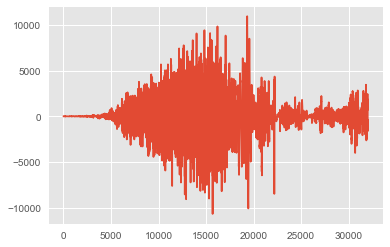

In [6]:
path = '../../processed_wavs_final_train'
from scipy.io import wavfile

prueba= train['fname'][0]
data = wavfile.read(path + "/" + prueba)
data = np.array((data[1][:]))
maximum_audio_frame = 1323000  # THIS WAS OBTAINED IN A FORMER RUN.
mul = maximum_audio_frame % len(data)
plt.plot(data)
plt.show()

In [5]:
data

array([    8,    11,    10, ..., -1620, -1095,  -941], dtype=int16)

In [9]:
data = data.astype(float)
n_mels = 96
audio_duration = 2000 # 2 seconds
fs= 32000 # we will make downsampling to save some data!!44100
n_fft = 2048
windows_size_s = 30 # 30 milisecons windowing (to have more context)
windows_size_f = (windows_size_s * fs ) // 1000  # int division # 960 samples
hop_length_samples = int(windows_size_f // 2) ## 480 samples
number_of_frames = fs * 2 # deprecated, use short audio in database already
fmax = int(fs / 2)
fmin = 0
normalize_audio = True
spectrogram_type = 'power'
maximum_mel = 0

mel_example = convert2mel(prueba,path,fs, n_fft,fmax,n_mels,hop_length_samples, windows_size_f)
mel_example.shape

(96, 97)

In [14]:
## prueba de audio replicado.

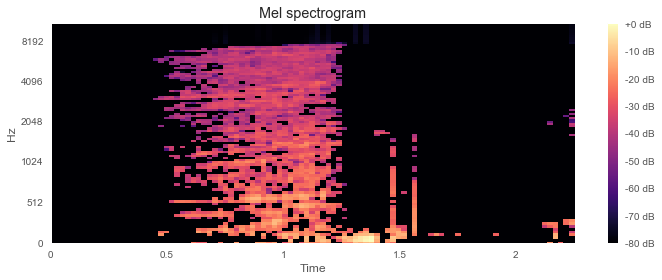

In [16]:
### mel spectrogram plot
import librosa.display
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_example,ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+1.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [ ]:
data_new = np.tile(data,mul)

In [ ]:
plt.plot(data_new)

In [54]:
import IPython.display as ipd  # To play sound in the notebook
fname = path + "/" + prueba
ipd.Audio(fname)

In [57]:
def get_fixed_length(audio, number_of_frames):
    if audio.shape[0] > number_of_frames:
        return np.delete(audio, np.arange(number_of_frames, audio.shape[0]), axis=0)
    elif audio.shape[0] < number_of_frames:
        mul = int(round(number_of_frames / audio.shape[0], 0))
        repeated_matrix = np.tile(audio.T, mul).T
        if repeated_matrix.shape[0] > number_of_frames:
            return np.delete(repeated_matrix, np.arange(number_of_frames, repeated_matrix.shape[0]), axis=0)
        return repeated_matrix
    else:
        return audio

In [59]:
get_fixed_length(mels.T, 100).shape

(100, 128)